In [8]:
# compare the data/mc veto efficiencies

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot
import os
import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

3.6.8 (default, Apr  2 2020, 13:34:55) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
years = ['16', '17', '18']
category = 0
ver = 'V1p17'
sig_ver = 'v52'
sig_ver = 'v78'
singleMuon = True
bkg_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/'+sig_ver+'/normalized/'
sig_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v48/normalized/'



# print("lumi is "+str(round(lumi/1000,2))+" fb-1")

if sig_ver == 'v52':fpath_bkg['dy_120_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root'
else:fpath_bkg['dy_120_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_137000pb_weighted.root'
for y in years:
    data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ver+'/Data20'+y+'/v5/'+sig_ver+'/normalized/'
    if y == '16':fpath_bkg['data'+y] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-ZMu-07Aug17_goodLumi.root"
    elif y == '17':fpath_bkg['data'+y] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root"
    else:fpath_bkg['data'+y] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-ZMu-17Sep2018_goodLumi.root"
    

fpath_bkg['signal'] = sig_path+"ggH_HToSSTobbbb_MH-125.root"





In [3]:
for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    a = tree_bkg[k]["weight"].array()
    print(a.shape)

dy_120_800 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/v78/normalized/ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_137000pb_weighted.root
(143196,)
data16 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2016/v5/v78/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-ZMu-07Aug17_goodLumi.root
(284928,)
data17 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2017/v5/v78/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root
(353888,)
data18 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/v5/v78/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-ZMu-17Sep2018_goodLumi.root
(499841,)
signal /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v48/normalized/ggH_HToSSTobbbb_MH-125.root
(50135,)


### Cluster efficiency

In [4]:
%%time
lumi = 1
###########
# 0: jetveto; 1:muon veto; 2: me11 veto; 3: me12 veto; 4: re12 veto; 5 mb1 segment veto; 6: rb1 veto; 7: mb1 rechit veto; 8: all rechit/segment vetos
###########
veto = 1
veto_names = ['jetVeto','muonVeto', 'me11Veto', 'me12Veto', 're12Veto', 'mb1Veto', 'rb1Veto','mb1RechitVeto','allVeto']
veto_yaxis = ['Jet Veto Efficiency','Muon Veto Efficiency','ME11 Veto Efficiency', 'ME12 Veto Efficiency', 'RE12 Veto Efficiency', 'MB1 Veto Efficiency', 'RB1 Veto Efficiency',\
              'MB1 Rechit Veto Efficiency','Rechit/Segment Veto Efficiency']


jetPt_cut = 50
tightid = False
pileupWeight = {}
weight = {}
ZPt = {}
ZMass = {}
nJets = {}
sel_lep = {}
sel_ev = {}
mc_corr_weight = {}
lepOverallSF = {}
nJets2 = {}
jetPt = {}
jetPhi = {}
jetEta = {}
muonPt = {}
muonPhi = {}
muonEta = {}
npu = {}
npv = {}
cscRechitClusterJetVetoPt = {}
cscRechitClusterEta = {}
cscRechitClusterPhi = {}
cscRechitCluster_match_gLLP_other_decay_r = {}
cscRechitCluster_match_gLLP_other_decay_z = {}
cscRechitClusterRE12 = {}
cscRechitClusterRB1 = {}
cscRechitClusterMB1 = {}
cscRechitClusterME11 = {}
cscRechitClusterMB1Rechit = {}
cscRechitClusterME12 = {}

re12_eta = {}
re12_phi = {}
rb1_eta = {}
rb1_phi = {}
mb1_phi = {}
mb1_eta = {}
mb1_rechit_eta = {}
mb1_rechit_phi = {}
me11_eta = {}
me11_phi = {}
me12_eta = {}
me12_phi = {}
all_eta = {}
all_phi = {}






rpcEta = {}
rpcPhi = {}
muonPt = 50
norm = 50
tag_probe = True
masses = [('120','800')]
cluster_index = '3'
for k, T in tree_bkg.items():
########## select cluster ########
    sel_rechitcluster = np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 2.0
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') <= 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') <= 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') <= 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') <= 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') <= 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') <= 0)
#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < 10)
    
    veto_sel = [T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < 10, 
    np.logical_and(T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') <= 0, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') <= 0),\
    np.logical_and(T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') <= 0, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') <= 0),\
     T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') <= 0,\
    T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= 0,\
     T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') <= 0,    \
     T.array('cscRechitCluster' + cluster_index + '_match_MB1_0p4') <= 0,\
         ]
#     if veto == 7:
#         veto_sel = [veto_sel[0]]
#     elif veto == 4 or veto == 6: 
#         veto_sel.pop(6)
#         veto_sel.pop(4)
#     else:
#         veto_sel.pop(6)
#         veto_sel.pop(veto)
    for v in veto_sel:
        sel_rechitcluster = np.logical_and(sel_rechitcluster, v)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') <= 20)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < 20)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0))
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc'))
    cond2 = np.logical_and(np.abs(T.array('cscRechitCluster' + cluster_index + 'AvgStation10'))==2, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 1.6)
    cond3 = np.logical_and(np.abs(T.array('cscRechitCluster' + cluster_index + 'AvgStation10'))==3, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 1.6)
    cond4 = np.logical_and(np.abs(T.array('cscRechitCluster' + cluster_index + 'AvgStation10'))==4, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 1.8)
    cond1 = np.logical_and(T.array('cscRechitCluster' + cluster_index + 'NStation10')==1, np.logical_or(np.logical_or(np.abs(T.array('cscRechitCluster' + cluster_index + 'AvgStation10'))==1, cond2), np.logical_or(cond3, cond4)))
    cond2 = np.logical_and(T.array('cscRechitCluster' + cluster_index + 'NStation10') > 1, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 1.9)
    bdt_sel = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
    sel_rechitcluster = np.logical_and(sel_rechitcluster,bdt_sel)

    print(k,np.count_nonzero(sel_rechitcluster.sum()))
# ########### BRANCHES ############
    if k == 'signal':
        sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )
        sel_ev[k] = T.array('METTrigger')
        sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('met') > 200)
        sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == category)
        sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('nLeptons') == 0)
        sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() == 1)
        sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
        sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
        sel_ev[k] = np.logical_and(sel_ev[k], np.sum(T.array('gLLP_csc'),axis = 1) > 0)
        cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        cscRechitClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        cscRechitClusterRE12[k] = T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        cscRechitClusterRB1[k] = T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        cscRechitClusterMB1[k] = T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        cscRechitClusterMB1Rechit[k] = T.array('cscRechitCluster' + cluster_index + '_match_MB1_0p4')[sel_rechitcluster][sel_ev[k]][:,0].flatten()


        cscRechitClusterME11[k] = (T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')+T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11'))\
        [sel_rechitcluster][sel_ev[k]][:,0].flatten()

        cscRechitClusterME12[k] = (T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')+T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12'))\
        [sel_rechitcluster][sel_ev[k]][:,0].flatten()






        
        cscRechitClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        cscRechitCluster_match_gLLP_other_decay_r[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_other_decay_r')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        cscRechitCluster_match_gLLP_other_decay_z[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_other_decay_z')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        weight[k] = (T.array('weight') * T.array('pileupWeight') * T.array('higgsPtWeight'))[sel_ev[k]]

    else:
        
        sel_lep[k] = np.logical_and(T.array('lepPassId')==1, T.array("lepPassTightIso")==1) #tight iso+id lepton
        sel_lep[k] = np.logical_and(sel_lep[k], np.abs(T.array("lepPdgId"))==13) #tight iso+id lepton
        sel_ev[k] = sel_lep[k].sum()>=1
        print(k,np.count_nonzero(sel_ev[k]))
        sel_ev[k] = np.logical_and(sel_ev[k], (T.array('lepPt')>= muonPt).sum()==2)
        if k[:2] == 'dy':sel_ev[k] = np.logical_and(sel_ev[k], T.array('lepFromZ').sum()==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T.array("Flag2_all"))
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('category')==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,136])
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=120)
        print(k,np.count_nonzero(sel_ev[k]))


        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')<800)
        print(k,np.count_nonzero(sel_ev[k]))
        weight[k] = T.array('weight')[sel_ev[k]]*lumi
        pileupWeight[k] = T.array('pileupWeight')[sel_ev[k]]
        if k[:2] == 'dy': lepOverallSF[k] = T.array('lepOverallSF')[sel_ev[k]]
    #         if k[:2] == 'dy': lepOverallSF[k] = pileupWeight[k]*0.0+1.0
        ZMass[k]= T.array('ZMass')[sel_ev[k]]
        ZMass[k]= T.array('ZMass')[sel_ev[k]]
        ZPt[k] = T.array('ZPt')[sel_ev[k]]
        nJets[k] = T.array('nJets')[sel_ev[k]]
        sel_jet = np.logical_and(np.abs(T.array('jetEta')) <=2.0, np.abs(T.array('jetEta')) >0.8)
        nJets2[k] = (sel_jet.sum())[sel_ev[k]]
        jetPt[k] = T.array('jetPt')[sel_jet][sel_ev[k]]
        jetEta[k] = T.array('jetEta')[sel_jet][sel_ev[k]]
        jetPhi[k] = T.array('jetPhi')[sel_jet][sel_ev[k]]
        
        sel_muon = np.logical_and(np.abs(T.array('muonEta')) <=2.0, np.abs(T.array('muonEta')) >0.8)
        muonEta[k] = T.array('muonEta')[sel_muon][sel_ev[k]]
        muonPhi[k] = T.array('muonPhi')[sel_muon][sel_ev[k]]
        
        re12_eta[k] = T.array('rpcEta')[T.array('rpc_RE12')][sel_ev[k]]
        re12_phi[k] = T.array('rpcPhi')[T.array('rpc_RE12')][sel_ev[k]]
        rb1_eta[k] = T.array('rpcEta')[T.array('rpc_RB1')][sel_ev[k]]
        rb1_phi[k] = T.array('rpcPhi')[T.array('rpc_RB1')][sel_ev[k]]
        mb1_phi[k] = T.array('dtSegPhi')[np.abs(T.array('dtSegStation')) == 1][sel_ev[k]]
        mb1_eta[k] = T.array('dtSegEta')[np.abs(T.array('dtSegStation')) == 1][sel_ev[k]]
        mb1_rechit_phi[k] = T.array('dtRechitsPhi')[np.abs(T.array('dtRechitsStation')) == 1][sel_ev[k]]
        mb1_rechit_eta[k] = T.array('dtRechitsEta')[np.abs(T.array('dtRechitsStation')) == 1][sel_ev[k]]
        
        me11_eta[k] = T.array('cscRechitsEta')[np.abs(T.array('cscRechitsChamber')) == 11][sel_ev[k]]
        me11_phi[k] = T.array('cscRechitsPhi')[np.abs(T.array('cscRechitsChamber')) == 11][sel_ev[k]]
        me12_eta[k] = T.array('cscRechitsEta')[np.abs(T.array('cscRechitsChamber')) == 12][sel_ev[k]]
        me12_phi[k] = T.array('cscRechitsPhi')[np.abs(T.array('cscRechitsChamber')) == 12][sel_ev[k]]
        
        all_eta[k] = awkward.JaggedArray.concatenate([me11_eta[k], me12_eta[k], re12_eta[k], mb1_eta[k], rb1_eta[k]], axis=1)
        all_phi[k] = awkward.JaggedArray.concatenate([me11_phi[k], me12_phi[k], re12_phi[k], mb1_phi[k], rb1_phi[k]], axis=1)




        mc_corr_weight[k] =  T.array('ZMass')[sel_ev[k]]
        if norm == 50:
            mc_corr_weight[k][np.logical_and(ZMass[k]>=50,ZMass[k]<120)] = 1.0734578
            mc_corr_weight[k][np.logical_and(ZMass[k]>=120,ZMass[k]<200)] = 1.1120967
            mc_corr_weight[k][np.logical_and(ZMass[k]>=200,ZMass[k]<400)] = 1.393718
            mc_corr_weight[k][np.logical_and(ZMass[k]>=400,ZMass[k]<800)] = 1.4190247
    #         cscRechitClusterJetVeto[k] = T.array('cscRechitCluster3JetVetoPt')[sel_cluster]

        if 'dy' in k:  weight[k] = (T.array('weight') * T.array('pileupWeight'))[sel_ev[k]] * mc_corr_weight[k] * lumi


        else: weight[k] = np.ones(ZMass[k].shape)
    npu[k] = T.array('npu')[sel_ev[k]]
    npv[k] = T.array('npv')[sel_ev[k]]
    print(k,np.sum(weight[k]),np.count_nonzero(sel_ev[k]))

dy_120_800 0
dy_120_800 143196
dy_120_800 141870
dy_120_800 141590
dy_120_800 1168423.4 141590
data16 0
data16 284928
data16 282206
data16 281735
data16 281735.0 281735
data17 0
data17 353888
data17 352500
data17 351838
data17 351838.0 351838
data18 0
data18 499841
data18 498120
data18 497190
data18 497190.0 497190
signal 13850
signal 0.09680602 13017
CPU times: user 2min, sys: 12.1 s, total: 2min 12s
Wall time: 3min 59s


# make jet cone

In [5]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while np.count_nonzero(dphi.flatten() > math.pi):
        dphi = dphi - (dphi > math.pi)*2*math.pi
    while np.count_nonzero(dphi.flatten() <= -math.pi):
        dphi = dphi + (dphi <= -math.pi)*2*math.pi
    return dphi


In [6]:
#phi is just random number betwen 0 and 359
# eta, took the distribution directly, no weights taken into account
CLUSTER_PER_EVT = 5
var_eta = [jetEta, muonEta, me11_eta, me12_eta, re12_eta, mb1_eta, rb1_eta, mb1_rechit_eta,all_eta]
var_phi = [jetPhi, muonPhi, me11_phi, me12_phi, re12_phi, mb1_phi, rb1_phi, mb1_rechit_phi,all_phi]
 


###########
# 0: jetveto; 1:muon veto; 2: me11 veto; 3: me12 veto; 4: re12 veto; 5 mb1 segment veto; 6: rb1 veto; 7: mb1 rechit veto; 8: all rechit/segment vetos
###########

matched = {}
for k in ['data16','data17','data18', 'dy_120_800']:
#     eta = np.random.randint(0,len(cscRechitClusterEta['signal']),CLUSTER_PER_EVT*len(jetPt[k]))
#     randomly pick the bin, and then randomly choose where in the bin it is
    hist, bins = np.histogram(np.abs(cscRechitClusterEta['signal']),bins = 48,range=[0.8,2.0],weights = weight['signal'])
    bin_width = bins[1]-bins[0]
    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    values = np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))
    pos_in_bin = (np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))-0.5)*bin_width
    signs = np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))
    signs[signs < 0.5] = -1
    signs[signs >= 0.5] = 1

    value_bins = np.searchsorted(cdf, values)
    
    eta = bin_midpoints[value_bins]*signs+pos_in_bin
    # for phi, randomly pick a point between 0,360
    phi = np.random.randint(0,360,CLUSTER_PER_EVT*len(var_eta[veto][k]))/180.0*math.pi

    # calculate deltaR between cluster the the jet/hits
    deltaR = ((eta-var_eta[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2+ \
              deltaPhi(phi,var_phi[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2)**0.5
#               awkward.fromiter(dphi)**2)**0.5
    print(len(deltaR))
    matched[k] = (deltaR<0.4).any()
    print(k, 1-np.count_nonzero(matched[k])/ len(deltaR))


1408675
data16 0.9680621860968641
1759190
data17 0.9684701481932025
2485950
data18 0.968212152295903
707950
dy_120_800 0.9686814040539586


# jet veto efficiency

data17 1759190.0 0.9684701481932025 0.0001317666064980516
dy_120_800 5842115.723817278 0.9683469347525909 0.0003911459205330955


Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorUp>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiency

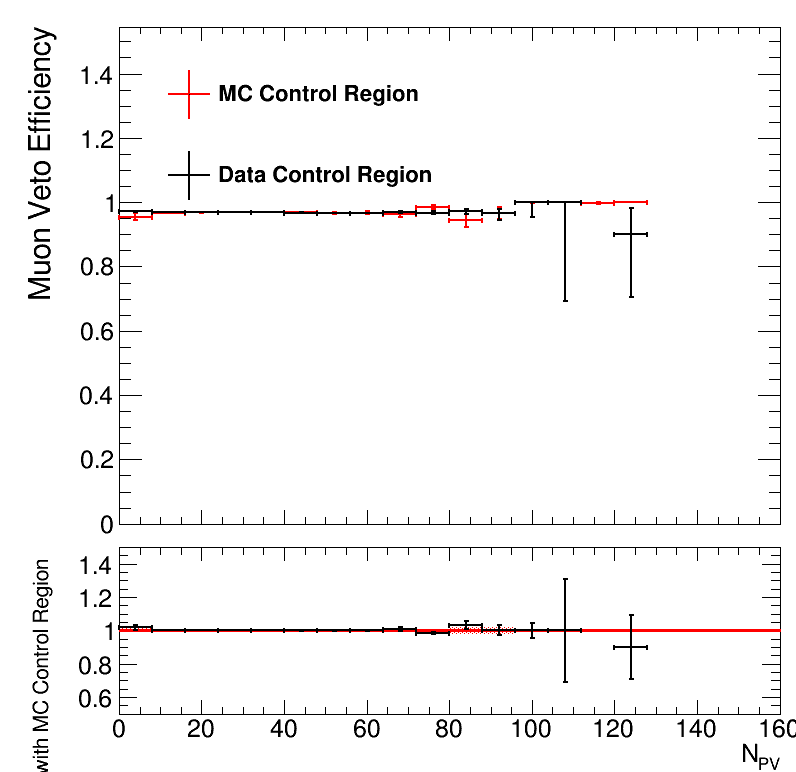

In [9]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.80,0.4,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
hm = {}
hb = {}
pEff = {}
var = [ZMass, ZPt, nJets, nJets2,npv]
title = ['Dimuon mass [GeV]', 'Z p_{T} [GeV]', 'Number of Jets', 'Number of Jets','N_{PV}']
bins = [ [25,120,800], [0,20,40,60,80,100,200,300,400,500,600,1200], [10,0,20], [15,0,15],  [20,0,160]]
names = ['ZMass','ZPt', 'nJets','nJets_eta2', 'npv']
ratio = [[0.5,1.5], [0.5,1.5], [0.5,1.5],[0.5,1.5],[0.5,1.5]]
assert(len(var) == len(title) == len(names) == len(bins)==len(ratio) )

dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/jet_veto_eff/'
if not os.path.isdir(dir_name):os.makedirs(dir_name)

reweight  =0
reweight_index = 1
for j in range(len(bins)):
    if not j == 4: continue
#     for i, k in enumerate(['data16','data17','data18','signal','dy_120_800',]):
    for i, k in enumerate(['data17','dy_120_800',]):


        if k == 'signal' and j != 4:continue
        total_weight = weight[k]
#         if 'dy' in k: total_weight *= lepOverallSF[k]
        if k == 'data': total_weight = total_weight * 0.0 + 1
        ###########
        # reweight
        ##########
        if k == 'dy_120_800' and reweight:
            print(np.sum(weight[k]))
            h_reweight = {}
            print("reweight",names[reweight_index], "plot", names[j])
            h_reweight['mc_reweight'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = total_weight)
            h_reweight['data_reweight'] = create_TH1D( np.abs(var[reweight_index]['data']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index])
            for key, v in h_reweight.items():v.Scale(1./v.Integral())
            h_reweight['data_reweight'].Divide(h_reweight['mc_reweight'])
            reweight = []
            for m in range(len(var[j][k])):
                reweight.append(h_reweight['data_reweight'].GetBinContent(h_reweight['data_reweight'].GetXaxis().FindFixBin(np.abs(var[reweight_index][k])[m])))
            total_weight = total_weight * np.array(reweight)


        if k == 'signal' and j == 4:
            outside = np.logical_or(cscRechitCluster_match_gLLP_other_decay_r[k]>300, np.abs(cscRechitCluster_match_gLLP_other_decay_z[k])>600)
            nominator = np.logical_and(outside, cscRechitClusterJetVetoPt[k]<10)
            if veto == 0: 
                outside = np.logical_or(cscRechitCluster_match_gLLP_other_decay_r[k]>300, np.abs(cscRechitCluster_match_gLLP_other_decay_z[k])>600)
                nominator = np.logical_and(outside, cscRechitClusterJetVetoPt[k]<10)
            elif veto == 1: 
                outside = np.logical_or(cscRechitCluster_match_gLLP_other_decay_r[k]>300, np.abs(cscRechitCluster_match_gLLP_other_decay_z[k])>650)
                nominator = np.logical_and(outside, cscRechitClusterME11[k]<=0)
            elif veto == 2: 
                outside = np.logical_or(cscRechitCluster_match_gLLP_other_decay_r[k]>500, np.abs(cscRechitCluster_match_gLLP_other_decay_z[k])>800)
                nominator = np.logical_and(outside, cscRechitClusterME12[k]<=0)
            elif veto == 3: 
                outside = np.logical_or(cscRechitCluster_match_gLLP_other_decay_r[k]>500, np.abs(cscRechitCluster_match_gLLP_other_decay_z[k])>800)
                nominator = np.logical_and(outside, cscRechitClusterRE12[k]<=0)
            elif veto == 4: 
                outside = np.logical_or(cscRechitCluster_match_gLLP_other_decay_r[k]>500, np.abs(cscRechitCluster_match_gLLP_other_decay_z[k])>700)
                nominator = np.logical_and(outside, cscRechitClusterMB1[k]<=0)
            elif veto == 5: 
                outside = np.logical_or(cscRechitCluster_match_gLLP_other_decay_r[k]>500, np.abs(cscRechitCluster_match_gLLP_other_decay_z[k])>700)
                nominator = np.logical_and(outside, cscRechitClusterRB1[k]<=0)
            elif veto == 6: 
                outside = np.logical_or(cscRechitCluster_match_gLLP_other_decay_r[k]>500, np.abs(cscRechitCluster_match_gLLP_other_decay_z[k])>700)
                nominator = np.logical_and(outside, cscRechitClusterMB1Rechit[k]<=0)
            elif veto == 7:
                outside = np.logical_or(cscRechitCluster_match_gLLP_other_decay_r[k]>500, np.abs(cscRechitCluster_match_gLLP_other_decay_z[k])>800)
                nominator = np.logical_and(outside, cscRechitClusterRE12[k]<=0)
                nominator = np.logical_and(nominator, cscRechitClusterMB1[k]<=0)
#                 nominator = np.logical_and(nominator, cscRechitClusterME11[k]<=0)
#                 nominator = np.logical_and(nominator, cscRechitClusterME12[k]<=0)
#                 nominator = np.logical_and(nominator, cscRechitClusterRB1[k]<=0)
            else: print("ERROR")
        
        


            print(len(nominator), len(var[j][k]))
            hm[k] = create_TH1D(np.abs(var[j][k][nominator]), 'hm1', axis_title = [title[j],veto_yaxis[veto]], binning=bins[j], weights = total_weight[nominator]) 
            hb[k] = create_TH1D(np.abs(var[j][k][outside]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], binning=bins[j], weights = total_weight[outside])
            
            m = create_TH1D(np.abs(var[j][k][nominator]), 'hm1', axis_title = [title[j],veto_yaxis[veto]], binning=[1,0,1000], weights = total_weight[nominator]) 
            b = create_TH1D(np.abs(var[j][k][outside]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], binning=[1,0,1000], weights = total_weight[outside])
            pEff_inclusive = rt.TEfficiency(m,b)
            print(k, pEff_inclusive.GetEfficiency(1), pEff_inclusive.GetEfficiencyErrorUp(1))
            
        else:
            hm[k] = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]), 'hm1',\
                                axis_title = [title[j],veto_yaxis[veto]], binning=bins[j], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]) 
            hb[k] = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], \
                                binning=bins[j], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)])
            m = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]), 'hm1',\
                                axis_title = [title[j],veto_yaxis[veto]], binning=[1,0,1000], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]) 
            b = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], \
                                    binning=[1,0,1000], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)])
            pEff_inclusive = rt.TEfficiency(m,b)
            print(k, b.Integral(), pEff_inclusive.GetEfficiency(1), pEff_inclusive.GetEfficiencyErrorUp(1))

        pEff[k] = rt.TEfficiency(hm[k],hb[k])
        pEff[k].SetLineColor(std_color_list[i])
        pEff[k].SetLineWidth(2)
        
        # inclusive efficiency calculation
        
        
        
#     if j == 4: c = make_ratio_pEff([pEff['dy_120_800'],pEff['data'],pEff['signal']], fit = False, logy=False, in_tags = ["MC Control Region","Data Control Region","MC Signal"],\
#                         ratio_bounds = ratio[j], draw_opt = ['E2','E1','E1']) 
#     else: 
#     c = make_ratio_pEff([pEff['dy_120_800'],pEff['data16'], pEff['data17'], pEff['data18']], fit = False, logy=False, \
#                         in_tags = ["MC","2016 data", '2017 data', '2018 data'], ratio_bounds = ratio[j], draw_opt = ['E2','E1', 'E1', 'E1']) 
#     print(pEff.keys())
#     c = make_ratio_pEff([pEff['data16'], pEff['data17'], pEff['data18']], fit = False, logy=False, \
#                         in_tags = ["2016 data", '2017 data', '2018 data'], ratio_index = 1, ratio_bounds = ratio[j], draw_opt = ['E1','E2','E1']) 
#     c.Draw()
#     c.SaveAs(dir_name+veto_names[veto]+'_eff_compareY_'+names[j]+'.png')
#     c.SaveAs(dir_name+veto_names[veto]+'_eff_compareY_'+names[j]+'.C')

    c = make_ratio_pEff([pEff['dy_120_800'],pEff['data17']], fit = False, logy=False, in_tags = ["MC Control Region","Data Control Region"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 
    c.Draw()

    if reweight: 
        c.SaveAs(dir_name+veto_names[veto]+'_eff'+names[j]+'_reweight'+names[reweight_index]+'.png')
        c.SaveAs(dir_name+veto_names[veto]+'_eff'+names[j]+'_reweight'+names[reweight_index]+'.png')
    else:
        c.SaveAs(dir_name+veto_names[veto]+'_eff'+names[j]+'.png')
        c.SaveAs(dir_name+veto_names[veto]+'_eff'+names[j]+'.C')

    



# distributions

1.0
data 351813.0 351814
11.706755
dy_120_800 354219.73833452706 141600


Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


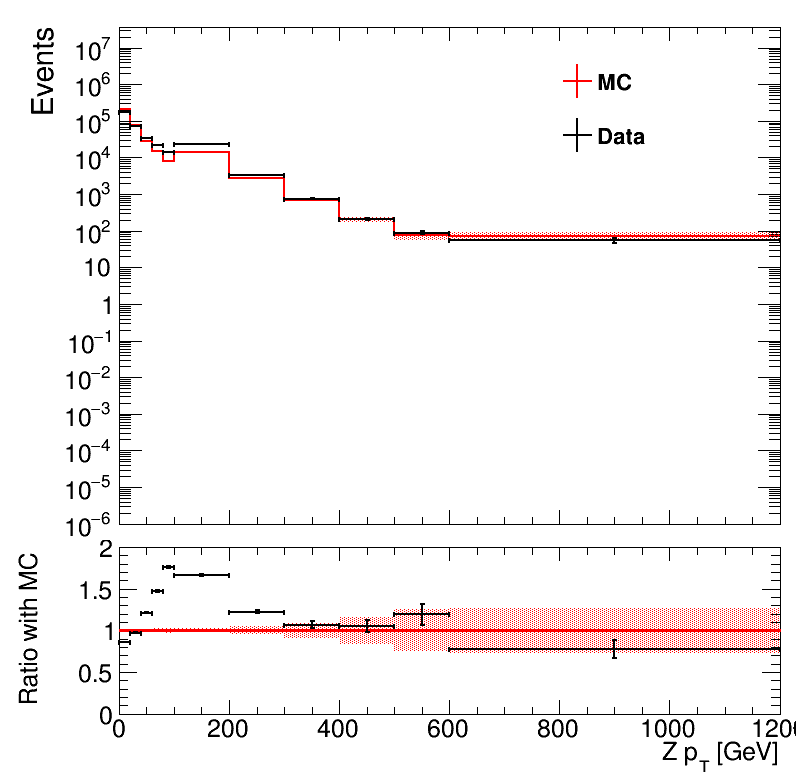

In [232]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.80,0.4,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
var = [ZMass, ZPt, nJets, nJets2,npv]
title = ['Dimuon mass [GeV]', 'Z p_{T} [GeV]', 'Number of Jets', 'Number of Jets','npv']
bins = [ [25,120,800], [0,20,40,60,80,100,200,300,400,500,600,1200], [10,0,20], [15,0,15], [20,0,160]]
names = ['ZMass','ZPt', 'nJets','nJets_eta2', 'npv']
ratio = [[0.5,1.5], [0.0,2], [0.5,1.5],[0.5,3],[0.5,5]]

assert(len(var) == len(title) == len(names) == len(bins)==len(ratio) )

dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/jet_veto_eff/'
if not os.path.isdir(dir_name):os.makedirs(dir_name)


reweight  = 0
reweight_index = 1
for j in range(len(bins)):
    if not j == 1: continue
    for i, k in enumerate(['data','dy_120_800']):

        total_weight = weight[k]
        print(weight[k][0])
#         if 'dy' in k: total_weight *= lepOverallSF[k]
        if 'data' in k: total_weight = total_weight * 0.0 + 1
        ###########
        # reweight
        ##########
        if ('dy' in k) and reweight:
            print(np.sum(total_weight))
            h_reweight = {}
            print("reweight",names[reweight_index], "plot", names[j])
            h_reweight['mc_reweight'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = total_weight)
            h_reweight['data_reweight'] = create_TH1D( np.abs(var[reweight_index]['data']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index])
            for key, v in h_reweight.items():v.Scale(1./v.Integral())
            h_reweight['data_reweight'].Divide(h_reweight['mc_reweight'])
            reweight = []
            for m in range(len(var[j][k])):
                reweight.append(h_reweight['data_reweight'].GetBinContent(h_reweight['data_reweight'].GetXaxis().FindFixBin(np.abs(var[reweight_index][k])[m])))
            print(weight[k][0])

            total_weight = total_weight * reweight

            
        
        h[k] = create_TH1D(np.abs(var[j][k]), 'hm1', axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight)
        h[k].SetLineColor(std_color_list[i])
        
        print(k,h[k].Integral(),len(total_weight))
    c = make_ratio_plot([h['dy_120_800'],h['data']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 
    c.Draw()
      
#     if not reweight:
#         c.SaveAs(dir_name+names[j]+'.png')
#         c.SaveAs(dir_name+names[j]+'.C')
#     else:
#         c.SaveAs(dir_name+names[j]+'_reweight'+names[reweight_index]+'.png')
#         c.SaveAs(dir_name+names[j]+'_reweight'+names[reweight_index]+'.png')




[10] [5]
